# Predicting Age and sex from images 

Practicing deep learning skills

A practice project from https://github.com/World-of-ML/DL-Simplified 

UTK face dataset from https://www.kaggle.com/datasets/jangedoo/utkface-new

In [1]:
data_dir = '/Users/lzhan/Desktop/DL_playground/age_sex_prediction/UTKFace/'

according to the dataset, the label is blend in the file names

`[age]_[gender]_[race]_[date&time].jpg`

- [age] is an integer from 0 to 116, indicating the age
- [gender] is either 0 (male) or 1 (female)
- [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

## Preprocess dataset: get label

In [2]:
from tqdm.notebook import tqdm
import os

In [3]:
images_path = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(data_dir)):
    image_path = os.path.join(data_dir, filename)
    age_label = int(filename.split('_')[0])
    # print (age_labels)
    gender_label = int(filename.split('_')[1])
    images_path.append(image_path)
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    # print(gender_labels)
    # break

  0%|          | 0/23708 [00:00<?, ?it/s]

View the first 5 of each and make sure everything works

In [4]:
images_path[:5]

['/Users/lzhan/Desktop/DL_playground/age_sex_prediction/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg',
 '/Users/lzhan/Desktop/DL_playground/age_sex_prediction/UTKFace/100_0_0_20170112215240346.jpg.chip.jpg',
 '/Users/lzhan/Desktop/DL_playground/age_sex_prediction/UTKFace/100_1_0_20170110183726390.jpg.chip.jpg',
 '/Users/lzhan/Desktop/DL_playground/age_sex_prediction/UTKFace/100_1_0_20170112213001988.jpg.chip.jpg',
 '/Users/lzhan/Desktop/DL_playground/age_sex_prediction/UTKFace/100_1_0_20170112213303693.jpg.chip.jpg']

In [5]:
gender_labels[:5]

[0, 0, 1, 1, 1]

In [6]:
age_labels[:5]

[100, 100, 100, 100, 100]

turn label into a dataframe

In [7]:
import pandas as pd

df_dict = {
    'image_path': images_path,
    'gender':gender_labels,
    'age': age_labels
}

df = pd.DataFrame(df_dict)

In [8]:
# View the first 5 of df
df.head()

,image_path,gender,age
0,/Users/lzhan/Desktop/DL_playground/age_sex_pre...,0,100
1,/Users/lzhan/Desktop/DL_playground/age_sex_pre...,0,100
2,/Users/lzhan/Desktop/DL_playground/age_sex_pre...,1,100
3,/Users/lzhan/Desktop/DL_playground/age_sex_pre...,1,100
4,/Users/lzhan/Desktop/DL_playground/age_sex_pre...,1,100


## Explore and preprocess image data

Text(0.5, 1.0, 'Male & female in UTK dataset')

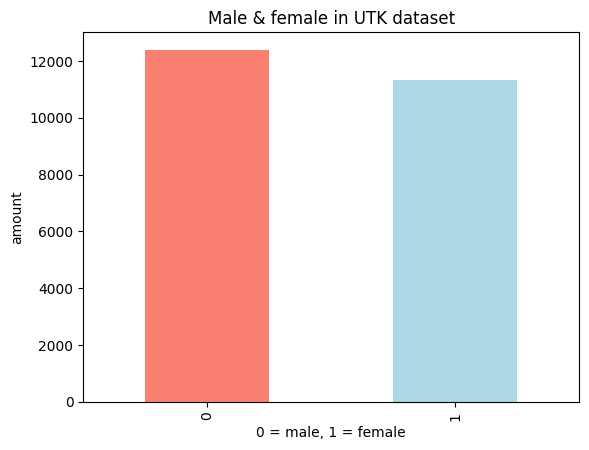

In [9]:
import matplotlib.pyplot as plt

gender_dict = {0:'Male', 
               1:'Female'}

df.gender.value_counts().plot(kind='bar', color=['salmon', 'lightblue'])
plt.xlabel('0 = male, 1 = female')
plt.ylabel('amount')
plt.title('Male & female in UTK dataset')

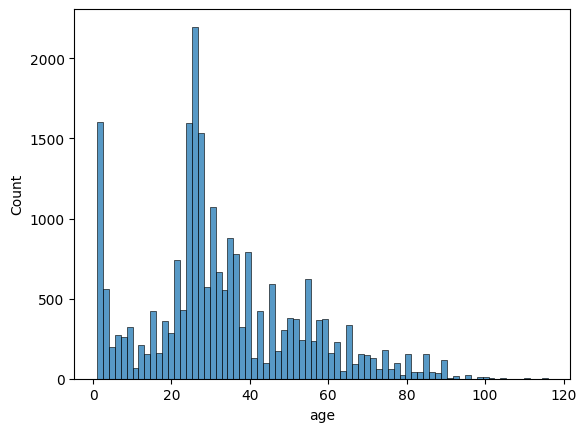

In [10]:
import seaborn as sns
sns.histplot(df['age']);

## Create tf dataset with images and labels

In [13]:
import tensorflow as tf

tf.random.set_seed(512)

def load_and_preprocess_image(image_path, img_size=(128, 128)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def create_tf_dataset(dataframe, img_size=(128, 128)):
    image_paths = dataframe['image_path'].values
    genders = dataframe['gender'].values
    ages = dataframe['age'].values
    
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = image_ds.map(lambda x: load_and_preprocess_image(x, img_size))
    
    gender_ds = tf.data.Dataset.from_tensor_slices(genders)
    age_ds = tf.data.Dataset.from_tensor_slices(ages)
    
    # Combine the three datasets
    dataset = tf.data.Dataset.zip((image_ds, (gender_ds, age_ds)))
    
    # Determine the number of elements in the dataset
    dataset_size = len(dataframe)
    
    # Compute the number of test examples
    test_size = int(dataset_size * 0.1)
    
    # Split the dataset into train and test
    test_ds = dataset.take(test_size)
    train_ds = dataset.skip(test_size)
    
    return train_ds, test_ds

In [14]:
train_ds, test_ds = create_tf_dataset(df, img_size=(128, 128))
train_ds = train_ds.shuffle(buffer_size=len(df))
train_ds = train_ds.batch(batch_size=32)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(buffer_size=len(df))
test_ds = test_ds.batch(batch_size=32)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
train_ds, test_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)))>)

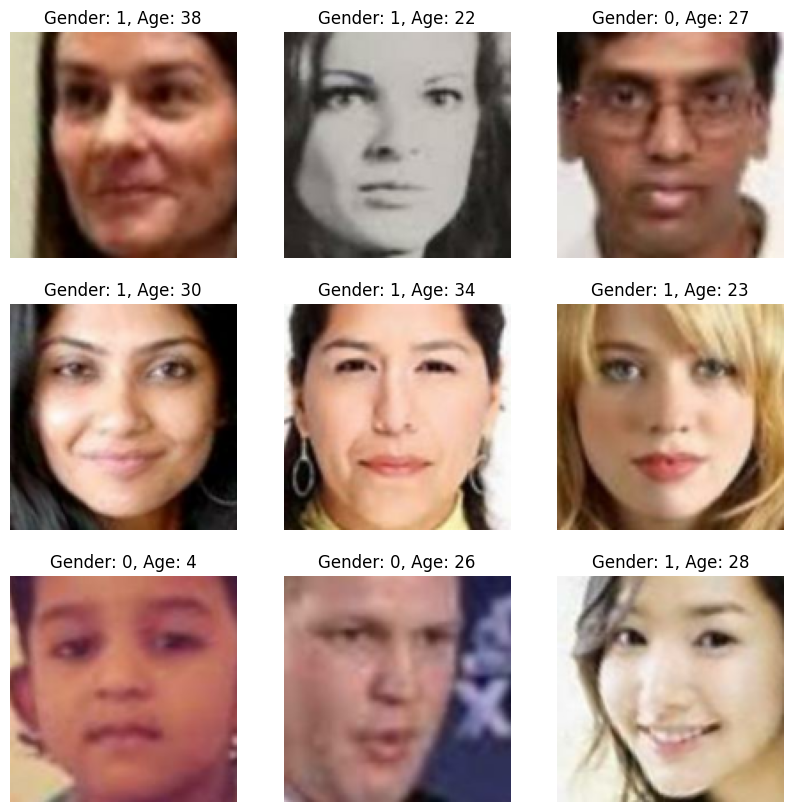

In [15]:
import numpy as np
def plot_images(dataset, num_images=9):
    # Take a batch of 'num_images' from the dataset
    batch = dataset.take(1).as_numpy_iterator()
    # Get the images and labels from the batch
    images, (genders, ages) = next(batch)
    # Create a grid for displaying the images
    fig, axes = plt.subplots(int(np.sqrt(num_images)), int(np.sqrt(num_images)), figsize=(10, 10))
    # Iterate through the images and plot them with their labels as titles
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"Gender: {genders[i]}, Age: {ages[i]}")
        ax.axis("off")
        
    plt.show()

plot_images(train_ds)

## Model1: baseline model

In [16]:
from tensorflow.keras import layers
inputs = layers.Input((128, 128, 3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
flatten = layers.Flatten()(x)
dense_1 = layers.Dense(256, activation='relu') (flatten)
dense_2 = layers.Dense(256, activation='relu') (flatten)
output_1 = layers.Dense(1, activation='sigmoid', name='gender_out') (dense_1)
output_2 = layers.Dense(1, activation='relu', name='age_out') (dense_2)
model = tf.keras.models.Model(inputs=[inputs], outputs = [output_1, output_2])
model.compile(optimizer='adam',
              loss={'gender_out': 'binary_crossentropy', 'age_out': 'mse'},
              metrics={'gender_out': 'accuracy', 'age_out': 'mae'})

In [17]:
history = model.fit(train_ds, batch_size=32, epochs=10)

Epoch 1/10
667/667 [==============================] - 19s 16ms/step - loss: 372.7555 - gender_out_loss: 0.6564 - age_out_loss: 372.0993 - gender_out_accuracy: 0.6081 - age_out_mae: 14.7486
Epoch 2/10
667/667 [==============================] - 17s 18ms/step - loss: 190.4695 - gender_out_loss: 0.4545 - age_out_loss: 190.0150 - gender_out_accuracy: 0.7960 - age_out_mae: 10.4548
Epoch 3/10
667/667 [==============================] - 18s 18ms/step - loss: 127.7021 - gender_out_loss: 0.3546 - age_out_loss: 127.3475 - gender_out_accuracy: 0.8484 - age_out_mae: 8.4711
Epoch 4/10
667/667 [==============================] - 18s 18ms/step - loss: 101.7496 - gender_out_loss: 0.3014 - age_out_loss: 101.4482 - gender_out_accuracy: 0.8725 - age_out_mae: 7.5238
Epoch 5/10
667/667 [==============================] - 19s 19ms/step - loss: 86.5828 - gender_out_loss: 0.2713 - age_out_loss: 86.3114 - gender_out_accuracy: 0.8871 - age_out_mae: 6.9082
Epoch 6/10
667/667 [==============================] - 19s 18

In [18]:
model.evaluate(test_ds)

75/75 [==============================] - 1s 8ms/step - loss: 88.1184 - gender_out_loss: 0.6038 - age_out_loss: 87.5145 - gender_out_accuracy: 0.6574 - age_out_mae: 6.2447


[88.11837768554688,
 0.603842556476593,
 87.51451110839844,
 0.6573839783668518,
 6.244656085968018]

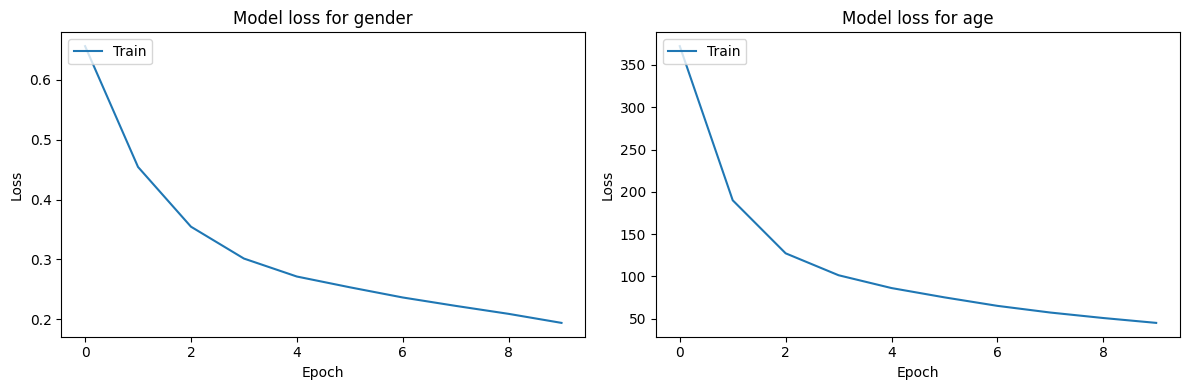

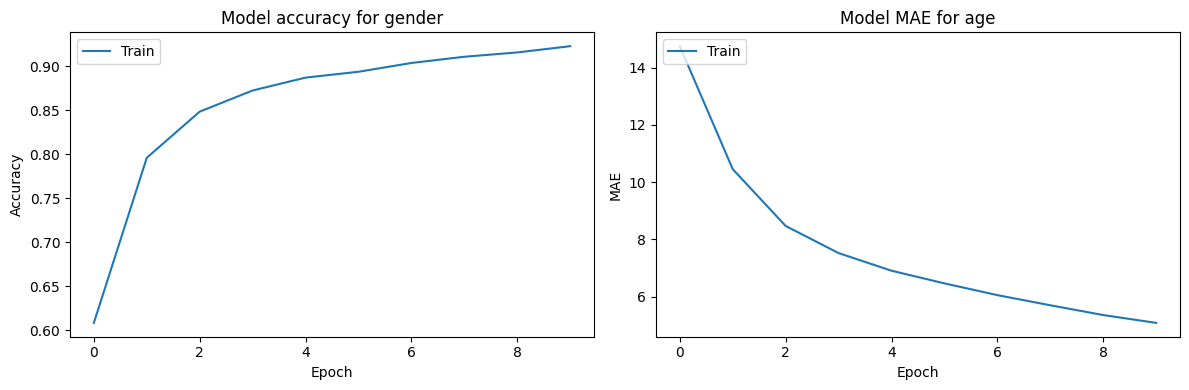

In [32]:
def plot_loss_curves(history): 
    # Plot training & validation loss values
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['gender_out_loss'])
    plt.title('Model loss for gender')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['age_out_loss'])
    plt.title('Model loss for age')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()

    # Plot training & validation accuracy values
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['gender_out_accuracy'])
    plt.title('Model accuracy for gender')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['age_out_mae'])
    plt.title('Model MAE for age')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()
    
plot_loss_curves(history)

## Model 2: VGG 19

In [26]:
from tensorflow.keras.applications import vgg19
from tensorflow.keras.layers import GlobalAveragePooling2D
vgg19 = vgg19.VGG19(include_top=False,
                    weights='imagenet',
                    input_shape=(128, 128, 3)
                    )

vgg19.trainable = True 

# Freeze all layers expect for the last 10 
for layer in vgg19.layers[:-10]:
    layer.trainable = False

In [35]:
inputs = layers.Input((128, 128, 3))
x = vgg19(inputs)
x = GlobalAveragePooling2D()(x)
output_1 = layers.Dense(1, activation='sigmoid', name='gender_out') (x)
output_2 = layers.Dense(1, activation='relu', name='age_out') (x)
model_2 = tf.keras.models.Model(inputs=[inputs], outputs = [output_1, output_2])
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss={'gender_out': 'binary_crossentropy', 'age_out': 'mse'},
              metrics={'gender_out': 'accuracy', 'age_out': 'mae'})

In [36]:
history_2 = model_2.fit(train_ds, batch_size=32, epochs=10)

Epoch 1/10
667/667 [==============================] - 50s 60ms/step - loss: 159.7577 - gender_out_loss: 0.8586 - age_out_loss: 158.8990 - gender_out_accuracy: 0.5591 - age_out_mae: 8.5430
Epoch 2/10
667/667 [==============================] - 49s 59ms/step - loss: 71.5079 - gender_out_loss: 0.6394 - age_out_loss: 70.8685 - gender_out_accuracy: 0.6436 - age_out_mae: 6.1240
Epoch 3/10
667/667 [==============================] - 50s 60ms/step - loss: 65.6451 - gender_out_loss: 0.6118 - age_out_loss: 65.0332 - gender_out_accuracy: 0.6746 - age_out_mae: 5.8591
Epoch 4/10
667/667 [==============================] - 50s 60ms/step - loss: 61.5620 - gender_out_loss: 0.5879 - age_out_loss: 60.9741 - gender_out_accuracy: 0.7002 - age_out_mae: 5.6681
Epoch 5/10
667/667 [==============================] - 50s 59ms/step - loss: 57.9392 - gender_out_loss: 0.5733 - age_out_loss: 57.3659 - gender_out_accuracy: 0.7075 - age_out_mae: 5.5051
Epoch 6/10
667/667 [==============================] - 52s 62ms/step 

In [37]:
model_2.evaluate(test_ds)

75/75 [==============================] - 3s 31ms/step - loss: 115.5623 - gender_out_loss: 0.7551 - age_out_loss: 114.8072 - gender_out_accuracy: 0.5118 - age_out_mae: 7.5648


[115.5622787475586,
 0.7550586462020874,
 114.80721282958984,
 0.5118143558502197,
 7.564767837524414]

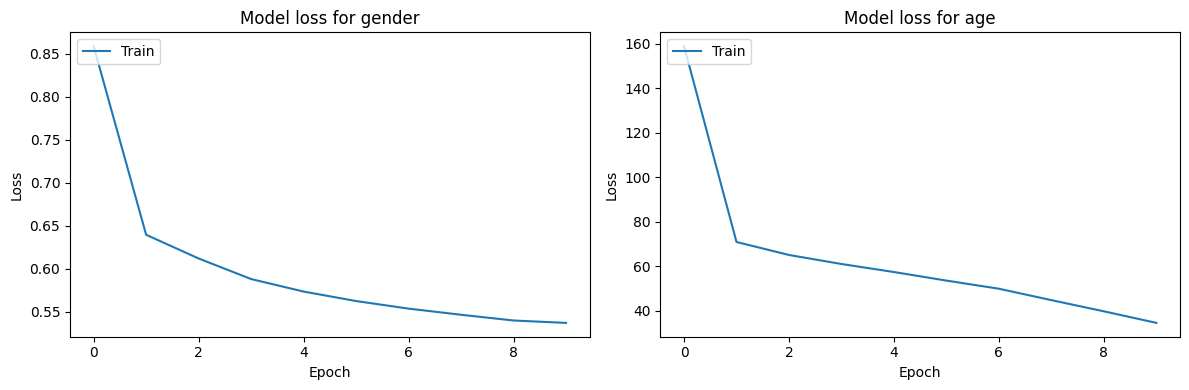

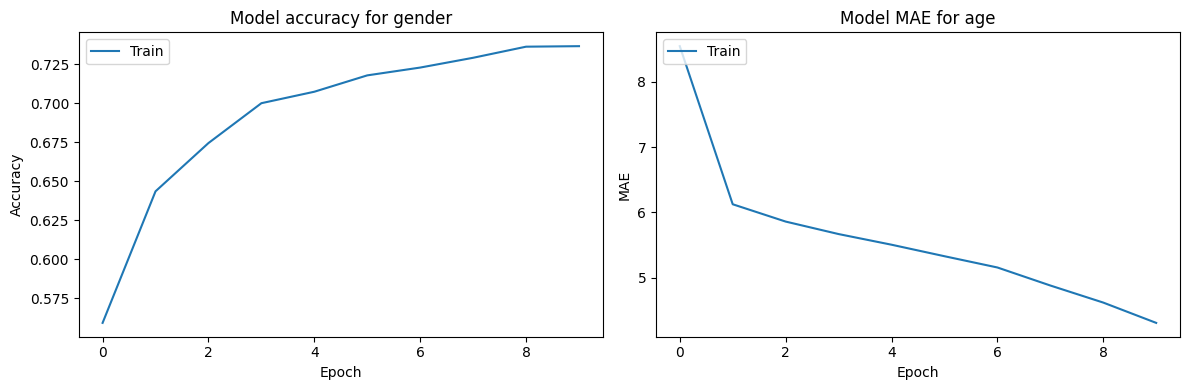

In [38]:
plot_loss_curves(history_2)

## Model 3: Xception

In [39]:
from tensorflow.keras.applications import xception
xception_model = xception.Xception(include_top=False,
                            weights='imagenet',
                            input_shape=(128, 128, 3)
                                )

xception_model.trainable = True 

# Freeze all layers expect for the last 10 
for layer in xception_model.layers[:-10]:
    layer.trainable = False
    
inputs = layers.Input((128, 128, 3))
x = xception_model(inputs)
x = GlobalAveragePooling2D()(x)
output_1 = layers.Dense(1, activation='sigmoid', name='gender_out') (x)
output_2 = layers.Dense(1, activation='relu', name='age_out') (x)
model_3 = tf.keras.models.Model(inputs=[inputs], outputs = [output_1, output_2])
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss={'gender_out': 'binary_crossentropy', 'age_out': 'mse'},
              metrics={'gender_out': 'accuracy', 'age_out': 'mae'})

history_3 = model_3.fit(train_ds, batch_size=32, epochs=10)

Epoch 1/10
667/667 [==============================] - 32s 28ms/step - loss: 647.0761 - gender_out_loss: 0.5719 - age_out_loss: 646.5043 - gender_out_accuracy: 0.7385 - age_out_mae: 21.0749
Epoch 2/10
667/667 [==============================] - 29s 28ms/step - loss: 107.7362 - gender_out_loss: 0.5641 - age_out_loss: 107.1722 - gender_out_accuracy: 0.7774 - age_out_mae: 7.7198
Epoch 3/10
667/667 [==============================] - 30s 29ms/step - loss: 79.8044 - gender_out_loss: 0.4835 - age_out_loss: 79.3209 - gender_out_accuracy: 0.8156 - age_out_mae: 6.7012
Epoch 4/10
667/667 [==============================] - 31s 29ms/step - loss: 69.2717 - gender_out_loss: 0.4256 - age_out_loss: 68.8461 - gender_out_accuracy: 0.8349 - age_out_mae: 6.2633
Epoch 5/10
667/667 [==============================] - 30s 28ms/step - loss: 60.6363 - gender_out_loss: 0.3858 - age_out_loss: 60.2506 - gender_out_accuracy: 0.8490 - age_out_mae: 5.8631
Epoch 6/10
667/667 [==============================] - 30s 28ms/st

In [40]:
model_3.evaluate(test_ds)

75/75 [==============================] - 3s 20ms/step - loss: 130.6045 - gender_out_loss: 0.7769 - age_out_loss: 129.8276 - gender_out_accuracy: 0.6148 - age_out_mae: 8.0406


[130.60447692871094,
 0.7769288420677185,
 129.8275909423828,
 0.6147679090499878,
 8.040563583374023]

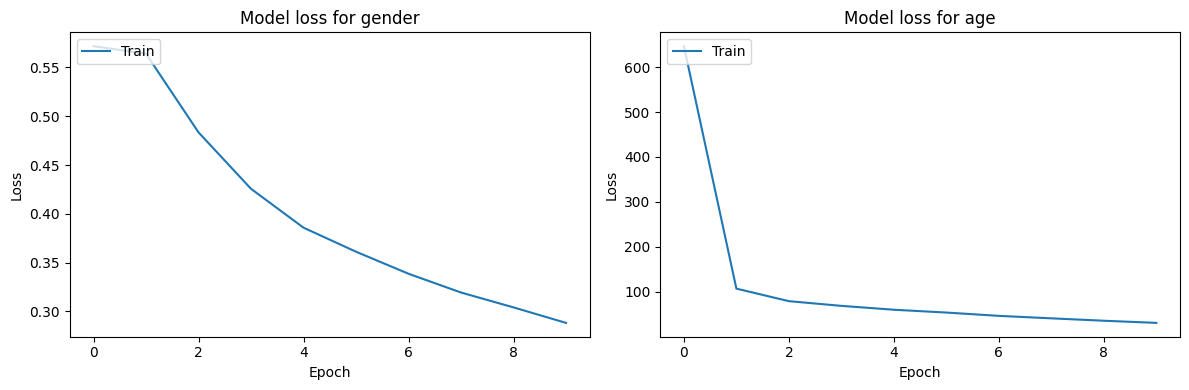

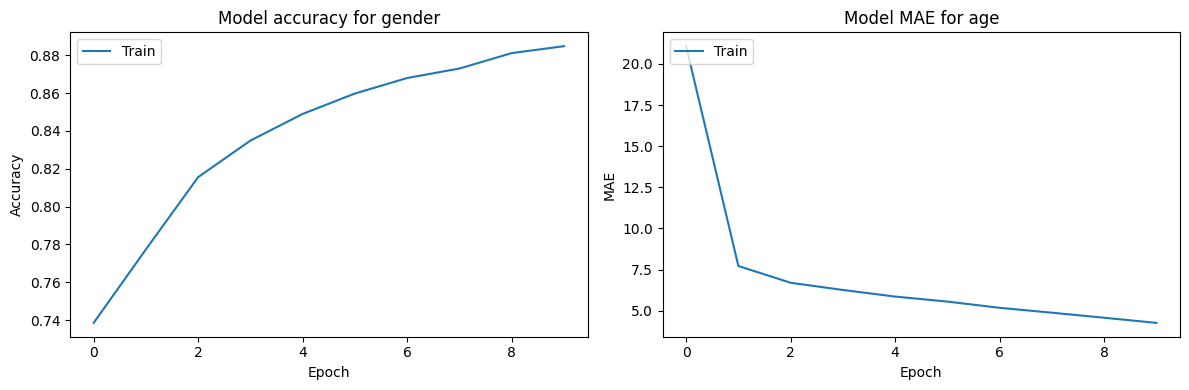

In [41]:
plot_loss_curves(history_3)

## Model_4: NASNet

In [44]:
from tensorflow.keras.applications import nasnet
nasnet_model = nasnet.NASNetLarge(include_top=False,
                                weights='imagenet',
                                input_shape=(128, 128, 3))

nasnet.trainable = True 

# Freeze all layers expect for the last 10 
for layer in nasnet_model.layers[:-10]:
    layer.trainable = False
    
inputs = layers.Input((128, 128, 3))
x = nasnet_model(inputs)
x = GlobalAveragePooling2D()(x)
output_1 = layers.Dense(1, activation='sigmoid', name='gender_out') (x)
output_2 = layers.Dense(1, activation='relu', name='age_out') (x)
model_4 = tf.keras.models.Model(inputs=[inputs], outputs = [output_1, output_2])
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss={'gender_out': 'binary_crossentropy', 'age_out': 'mse'},
              metrics={'gender_out': 'accuracy', 'age_out': 'mae'})

history_4 = model_4.fit(train_ds, batch_size=32, epochs=10)

Epoch 1/10
667/667 [==============================] - 83s 78ms/step - loss: 817.2245 - gender_out_loss: 0.4213 - age_out_loss: 816.8037 - gender_out_accuracy: 0.8047 - age_out_mae: 22.3307
Epoch 2/10
667/667 [==============================] - 68s 79ms/step - loss: 356.5780 - gender_out_loss: 0.3354 - age_out_loss: 356.2426 - gender_out_accuracy: 0.8594 - age_out_mae: 13.4063
Epoch 3/10
667/667 [==============================] - 69s 79ms/step - loss: 288.1203 - gender_out_loss: 0.3201 - age_out_loss: 287.8004 - gender_out_accuracy: 0.8659 - age_out_mae: 12.2175
Epoch 4/10
667/667 [==============================] - 78s 93ms/step - loss: 260.9006 - gender_out_loss: 0.3112 - age_out_loss: 260.5895 - gender_out_accuracy: 0.8700 - age_out_mae: 11.7179
Epoch 5/10
667/667 [==============================] - 79s 92ms/step - loss: 242.4014 - gender_out_loss: 0.3050 - age_out_loss: 242.0963 - gender_out_accuracy: 0.8723 - age_out_mae: 11.3292
Epoch 6/10
667/667 [==============================] - 7

In [45]:
model_4.evaluate(test_ds)

75/75 [==============================] - 14s 82ms/step - loss: 201.7991 - gender_out_loss: 0.6277 - age_out_loss: 201.1714 - gender_out_accuracy: 0.6439 - age_out_mae: 10.1940


[201.79905700683594,
 0.6276838183403015,
 201.17138671875,
 0.6438818573951721,
 10.194019317626953]

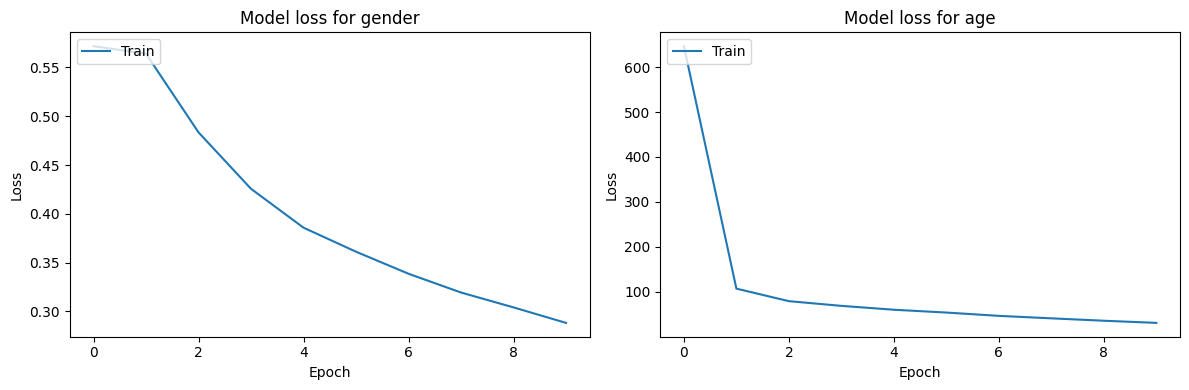

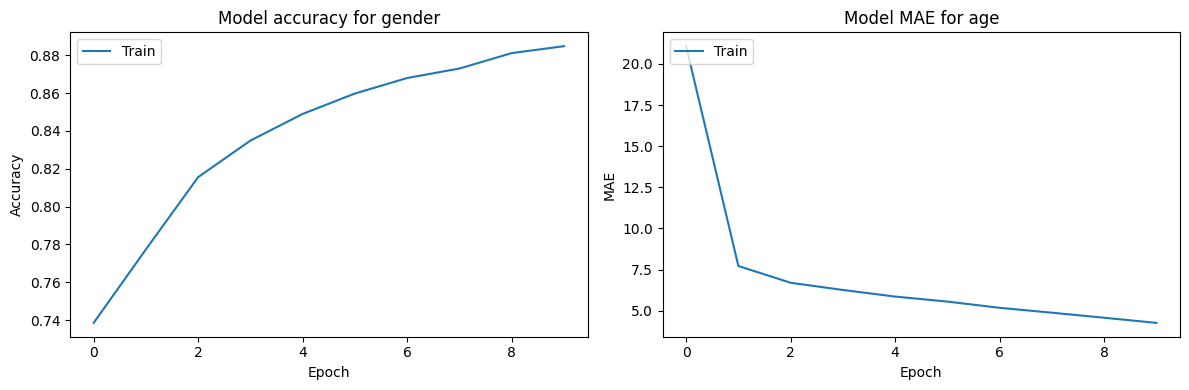

In [46]:
plot_loss_curves(history_3)

## Make predictions with random images from the dataset

In [63]:
def plot_predictions(model, dataset, num_images=9):
    # Randomly select a batch from the dataset
    batch = dataset.shuffle(buffer_size=len(df)).take(1).as_numpy_iterator()
    images, (true_genders, true_ages) = next(batch)
    predicted_genders, predicted_ages = model.predict(images)
    
    predicted_genders = np.round(predicted_genders).astype(np.int32)
    predicted_ages = np.round(predicted_ages).astype(np.int32)
    
    # Create a grid for displaying the images
    fig, axes = plt.subplots(int(np.sqrt(num_images)), int(np.sqrt(num_images)), figsize=(10, 10))
        
    # Iterate through the images and plot them with true and predicted labels as titles
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"True: (Gen: {true_genders[i]}, Age: {true_ages[i]})\nPred: (Gen: {predicted_genders[i]}, Age: {predicted_ages[i]})")
        ax.axis("off")
        
    plt.show()

1/1 [==============================] - 0s 27ms/step


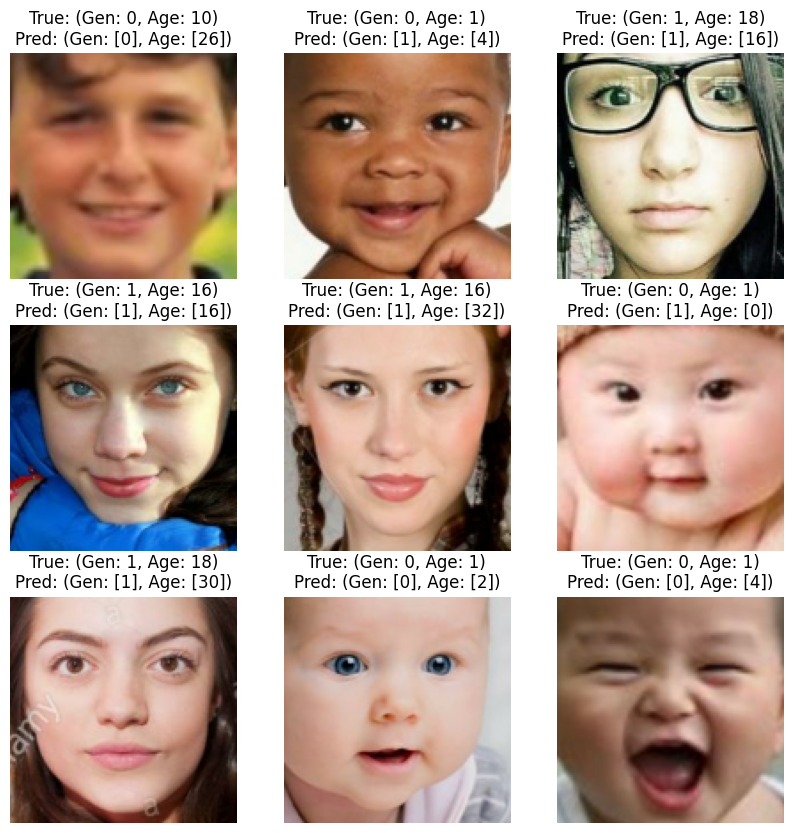

In [64]:
plot_predictions(model_3, test_ds, num_images=9)